<a name="pagetop"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Plotting Satellite Data</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>

### Questions
1. Where are current GOES data available?
1. How can satellite data be obtained with Siphon?
1. How can MetPy simplify metadata parsing?
1. How can maps of satellite data be made?

### Table of Contents
1. <a href="#findingdata">Finding GOES data</a>
1. <a href="#dataaccess">Accessing data with Siphon</a>
1. <a href="#parse">Digging into and parsing the data</a>
1. <a href="#plotting">Plotting the data</a>

<hr style="height:2px;">

<a name="findingdata"></a>
## Finding GOES Data

The first step is to find the satellite data. Normally, we would browse over to http://thredds.ucar.edu/thredds/ and find the top-level [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) catalog. From there we can drill down to find satellite data products.

For current data, you could navigate to the `Satellite Data` directory, then `GOES East Products` and `CloudAndMoistureImagery`. There are subfolders for the CONUS, full disk, mesoscale sector images, and other products. In each of these is a folder for each [channel of the ABI](https://www.goes-r.gov/mission/ABI-bands-quick-info.html). In each channel there is a folder for every day in the approximately month-long rolling archive. As you can see, there are a massive amount of data coming down from GOES-16!

In the next section we'll be downloading the data in a pythonic way, so our first task is to build a URL that matches the URL we manually navigated to in the web browser. To make it as flexible as possible, we'll want to use variables for the sector name (CONUS, full-disk, mesoscale-1, etc.), the date, and the ABI channel number.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>Create variables named image_date, region, and channel. Assign them to today's date, the mesoscale-1 region, and ABI channel 8. </li>
         <li>Construct a string data_url from these variables and the URL we navigated to above.</li>
         <li>Verify that following your link will take you where you think it should.</li>
         <li>Change the extension from catalog.html to catalog.xml. What do you see?</li>
    </ul>
</div>


In [1]:
from datetime import datetime

# Create variables for URL generation
# YOUR CODE GOES HERE

# Construct the data_url string
# YOUR CODE GOES HERE

# Print out your URL and verify it works!
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [2]:
# %load solutions/data_url.py


# Cell content replaced by load magic replacement.
from datetime import datetime

# Create variables for URL generation
image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 8

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string
data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{image_date:%Y%m%d}/catalog.xml')

# Print out your URL and verify it works!
print(data_url)


https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel08/20200904/catalog.xml


<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="dataaccess"></a>
## Accessing data with Siphon

We could download the files to our computers from the THREDDS web interface, but that can become tedious for downloading many files, requires us to store them on our computer, and does not lend itself to automation.

We can use [Siphon](https://github.com/Unidata/siphon) to parse the catalog from the TDS. This provides us a nice programmatic way of accessing the data. We start by importing the `TDSCatalog` class from siphon and giving it the URL to the catalog we just surfed to manually. **Note:** Instead of giving it the link to the HTML catalog, we change the extension to XML, which asks the TDS for the XML version of the catalog. This is much better to work with in code. If you forget, the extension will be changed for you with a warning being issued from siphon.

We want to create a `TDSCatalog` object called `cat` that we can examine and use to get handles to work with the data.

In [3]:
from siphon.catalog import TDSCatalog

In [4]:
cat = TDSCatalog(data_url)

To find the latest file, we can look at the `cat.datasets` attribute. Let’s look at the first five datasets:

In [5]:
cat.datasets[:5]

[OR_ABI-L2-CMIPC-M6C08_G16_s20202481536150_e20202481536150_c20202481536150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20202481531150_e20202481531150_c20202481531150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20202481526150_e20202481526150_c20202481526150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20202481521150_e20202481521150_c20202481521150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20202481516150_e20202481516150_c20202481516150.nc]

In [6]:
cat.datasets[0]

OR_ABI-L2-CMIPC-M6C08_G16_s20202481536150_e20202481536150_c20202481536150.nc

We'll get the next to most recent dataset (sometimes the most recent will not have received all tiles yet) and store it as variable `dataset`. Note that we haven't actually downloaded or transferred any real data yet, just bits of metadata have been received from THREDDS and parsed by siphon.

In [7]:
dataset = cat.datasets[1]

In [8]:
print(dataset)

OR_ABI-L2-CMIPC-M6C08_G16_s20202481531150_e20202481531150_c20202481531150.nc


We're finally ready to get the actual data. We could download the file, then open that, but there is no need! We can use siphon to help us only get what we need and hold it in memory. Notice that we're using the XArray accessor which will make life much nicer that dealing with the raw netCDF (like we used to back in the days of early 2018).

In [9]:
ds = dataset.remote_access(use_xarray=True)

<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="parse"></a>
## Digging into and parsing the data

Now that we've got some data - let's see what we actually got our hands on.

In [10]:
ds

<xarray.Dataset>
Dimensions:               (x: 2500, y: 1500)
Coordinates:
    time                  datetime64[ns] ...
  * y                     (y) float32 128212.0 128156.0 ... 44324.0 44268.0
  * x                     (x) float32 -101332.0 -101276.0 ... 38556.0 38612.0
Data variables:
    Sectorized_CMI        (y, x) float32 ...
    fixedgrid_projection  int32 ...
Attributes:
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  8
    central_wavelength:          6.19
    abi_mode:                    6
    source_scene:                CONUS
    periodicity:                 5.0
    production_location:         RBU
    product_name:                ECONUS-020-B12-M6C08
    satellite_id:                GOES-16
    product_center_latitude:     30.08300267372796
    product_center_longitude:    -87.09695844824527
    projection:                  Fixed Grid
    bit_depth:                   12
    source_spatial_resolution:   2.0
    request_spatial_resolution:  2.0
    start_date_time:             2020248153115
    number_product_tiles:        15
    product_tile_width:          512
    product_tile_height:         512
    product_rows:                1500
    product_columns:             2500
    pixel_x_size:                2.0
    pixel_y_size:                2.0
    satellite_latitude:          0.0
    satellite_longitude:         -75.0
    satellite_altitude:          35786023.0
    created_by:                  ldm-alchemy
    product_tiles_received:      15

Great, so we have an XArray Dataset object, something we've dealt with before! We also see that we have the coordinates `time`, `y`, and `x` as well as the data variables of `Sectorized_CMI` and the projection information. Using the MetPy accessor for xarray, we can pull out the data we need for plotting.

In [11]:
import metpy
dat = ds.metpy.parse_cf('Sectorized_CMI')
proj = dat.metpy.cartopy_crs
x = dat['x']
y = dat['y']

<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="plotting"></a>
## Plotting the Data

To plot our data we'll be using CartoPy and matplotlib:

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

Let's first make a simple plot using CartoPy's built-in shapefiles.

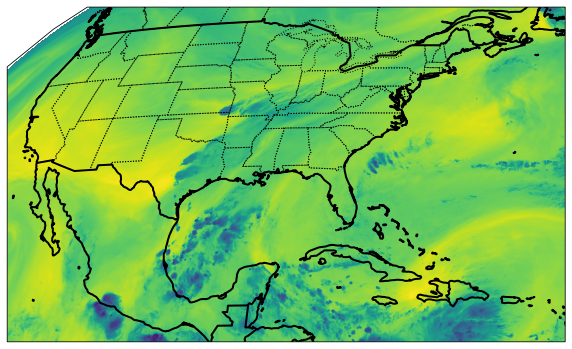

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>Look at the documentation for metpy.plots.colortables <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.ColortableRegistry.html#colortableregistry">here</a> and figure out how to set the colormap of the image. For this image, let's go with the WVCIMSS_r colormap as this is a mid-level water vapor image. To see all of the colortables that MetPy supports, check out this <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html">page</a></li>
         <li>BONUS: Use the MetPy add_timestamp method from metpy.plots to add a timestamp to the plot.</li>
         <li>DAILY DOUBLE: Using the start_date_time attribute on the dataset ds, change the call to add_timestamp to use that date and time and the pretext to say "GOES 16 Channel X".</li>
    </ul>
</div>


In [14]:
#Import for colortables
from metpy.plots import colortables

# Import for the bonus exercise
from metpy.plots import add_timestamp

# Make the image plot
# YOUR CODE GOES HERE


<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

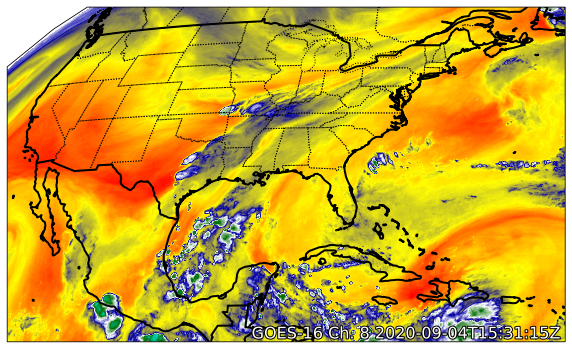

In [15]:
# %load solutions/sat_map.py


# Cell content replaced by load magic replacement.
#Import for colortables
from metpy.plots import colortables

# Import for the bonus exercise
from metpy.plots import add_timestamp

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

wv_cmap = colortables.get_colortable('WVCIMSS_r')
im.set_cmap(wv_cmap)

#Bonus
start_time = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
add_timestamp(ax, time=start_time, pretext=f'GOES-16 Ch. {channel} ',
              high_contrast=True, fontsize=16, y=0.01)

plt.show()

### More about Colortables
Colormapping in matplotlib (which backs CartoPy) is handled through two pieces:

- The norm (normalization) controls how data values are converted to floating point values in the range [0, 1]
- The colormap controls how values are converted from floating point values in the range [0, 1] to colors (think colortable)

Let's try to determine a good range of values for the normalization. We'll make a histogram to see the distribution of values in the data, then clip that range down to enhance contrast in the data visualization.

We use `compressed` to remove any masked elements before making our histogram (areas of space that are in the view of the satellite).

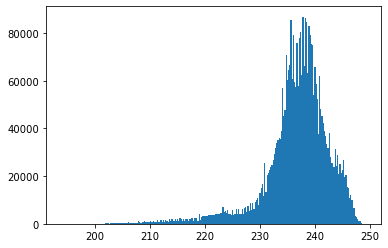

In [16]:
import matplotlib.pyplot as plt
plt.hist(ds['Sectorized_CMI'].to_masked_array().compressed(), bins=255);

In meteorology, we have many ‘standard’ colortables that have been used for certain types of data. We have included these in Metpy in the `metpy.plots.ctables` module. The `WVCIMSS` colormap is a direct conversion of a GEMPAK colormap. Let's remake that image with a range of 195 to 265 K. This was empirically determined to closely match other displays of water vapor data.

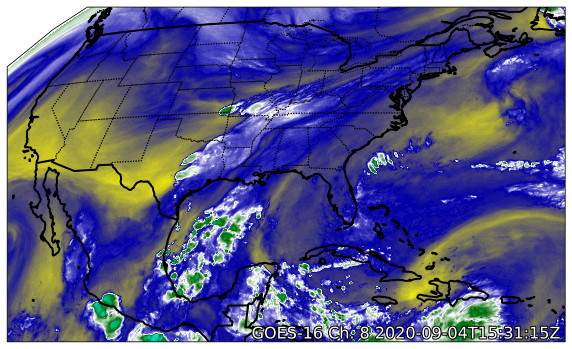

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 195, 265)
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)

start_time = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
add_timestamp(ax, time=start_time, pretext=f'GOES-16 Ch. {channel} ',
              high_contrast=True, fontsize=16, y=0.01)
plt.show()

<a href="#pagetop">Top</a>
<hr style="height:2px;">